In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data

from torchvision import transforms
from torchvision.models import resnet18

import string
from tqdm.notebook import tqdm
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp

import json
import time

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Loading Datasets and Preprocessing

In [3]:
license_df = pd.read_csv('data/dataset.csv', header=None)
print(license_df.head(), license_df.shape)

                    0        1
0  crop_m1/I00000.png  9B52145
1  crop_h1/I00000.png  9B52145
2  crop_m1/I00001.png  6B94558
3  crop_h1/I00001.png  6B94558
4  crop_m1/I00002.png  8B90164 (652, 2)


##### Converting Dataset (dataset.csv)  into Json file (license_dataset.json) and creating instance of LicensePlateDataset to easily work with CRNN  (CNN + RNN) archiecture and pytorch framework <br>
###### Running (data/create_dataset.py) which outputs (license_dataset.json) <br>

In [4]:
pretrained_size = (120, 400)
data_path = 'data/'

In [5]:
class LicensePlateDataset(Dataset):
    def __init__(self, data_path):
        super().__init__()
        self.data_path = data_path
        self.config = json.load(open(os.path.join(data_path, "license_dataset.json")))

    def vocabs_len(self):
        return len(self.config["vocabs"])

    def get_vocabs(self):
        return self.config["vocabs"]

    def __len__(self):
        return len(self.config['train'])

    def __getitem__(self, idx):
        name = self.config['train'][idx]["name"]
        text = self.config['train'][idx]["text"]
        
        image = Image.open(os.path.join(self.data_path, name)).convert('RGB')
        image = self.transform(image)

        return image, text
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.Resize(pretrained_size),
            transforms.RandomRotation(5),
            transforms.RandomCrop(pretrained_size, padding = 10),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [6]:
datasets = LicensePlateDataset(data_path)
print(len(datasets)) 

652


### Splitting datasets into training and validation sets¶


In [7]:
VALID_RATIO = 0.8

n_train_examples = int(len(datasets) * VALID_RATIO)
n_valid_examples = len(datasets) - n_train_examples

In [8]:
train_data, valid_data = data.random_split(datasets, 
                                           [n_train_examples, n_valid_examples])
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')

Number of training examples: 521
Number of validation examples: 131


### Visualizing some of images 

In [9]:
def plot_images(images, labels):
    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (5, 5))

    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image = images[i]
        ax.imshow(image.permute(1, 2, 0).numpy())
        ax.set_title(labels[i])
        ax.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


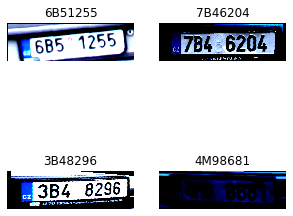

In [10]:
N_IMAGES = 4

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

plot_images(images, labels)

In [11]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
print(len(train_loader), len(test_loader))

33 9


In [12]:
image_batch, text_batch = iter(train_loader).next()
print(image_batch.size(), text_batch)

torch.Size([16, 3, 120, 400]) ('4B83940', '4E02304', '8B60552', '6B24616', '1B27247', '3M46918', '4B86157', '4B01832', '4B83940', 'SI625BC', '2B38280', '7B76600', '5B28893', '4M26776', '9B43104', 'FMR4437')


In [13]:
# possible charactes outcomes
idx2char = {k:v for k,v in enumerate(datasets.get_vocabs(), start=0)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: '0', 27: '1', 28: '2', 29: '3', 30: '4', 31: '5', 32: '6', 33: '7', 34: '8', 35: '9'}
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, '0': 26, '1': 27, '2': 28, '3': 29, '4': 30, '5': 31, '6': 32, '7': 33, '8': 34, '9': 35}


### Creating CRNN Architecture to train on images of license plates 

In [14]:
# Hyperparameters
num_chars = len(datasets.get_vocabs())
print(f'CRNN Output size: {num_chars}')
rnn_hidden_size = 256
num_epochs = 50
lr = 0.001
weight_decay = 1e-3
clip_norm = 5

CRNN Output size: 36


In [15]:
# Using Resnet18 as base convolution model
resnet = resnet18(pretrained=True)

In [16]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )
        
        self.linear1 = nn.Linear(512, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
#         print(batch.size())
        
        batch = self.cnn_p2(batch)
#         print(batch.size())
        
        batch = batch.permute(0, 3, 1, 2)
#         print(batch.size())
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1)
#         print(batch.size())
        
        batch = self.linear1(batch)
#         print(batch.size())
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
#         print(batch.size())
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size())
        
        batch = self.linear2(batch)
        # print(batch.size())
        
        batch = batch.permute(1, 0, 2)
        # print(batch.size())
        
        return batch

In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [18]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [19]:
print(crnn)

CRNN(
  (cnn_p1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(crnn):,} trainable parameters')

The model has 5,101,796 trainable parameters


In [21]:
criterion = nn.CTCLoss(blank=0)
optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

In [22]:
def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
#     print(text_batch_logps.shape)
#     print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [23]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [24]:
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('4B83940', '4E02304', '8B60552', '6B24616', '1B27247', '3M46918', '4B86157', '4B01832', '4B83940', 'SI625BC', '2B38280', '7B76600', '5B28893', '4M26776', '9B43104', 'FMR4437')
torch.Size([11, 16, 36])


In [25]:
loss = compute_loss(text_batch, text_batch_logits)
print(loss.item())

4.589910984039307


### Training  

In [26]:
epoch_losses = []
iteration_losses = []
for epoch in tqdm(range(1, num_epochs+1)):
    start_time = time.monotonic()
    
    epoch_loss_list = [] 
    for image_batch, text_batch in tqdm(train_loader, leave=False):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    epoch_loss = np.mean(epoch_loss_list)
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'Train Loss: {epoch_loss:.3f}')
    epoch_losses.append(epoch_loss)
    lr_scheduler.step(epoch_loss)

Epoch: 01 | Epoch Time: 0m 6s
Train Loss: 3.059


Epoch: 02 | Epoch Time: 0m 6s
Train Loss: 2.690


Epoch: 03 | Epoch Time: 0m 6s
Train Loss: 2.606


Epoch: 04 | Epoch Time: 0m 6s
Train Loss: 2.569


Epoch: 05 | Epoch Time: 0m 6s
Train Loss: 2.532


Epoch: 06 | Epoch Time: 0m 6s
Train Loss: 2.499


Epoch: 07 | Epoch Time: 0m 6s
Train Loss: 2.490


Epoch: 08 | Epoch Time: 0m 6s
Train Loss: 2.460


Epoch: 09 | Epoch Time: 0m 6s
Train Loss: 2.435


Epoch: 10 | Epoch Time: 0m 6s
Train Loss: 2.432


Epoch: 11 | Epoch Time: 0m 6s
Train Loss: 2.422


Epoch: 12 | Epoch Time: 0m 6s
Train Loss: 2.417


Epoch: 13 | Epoch Time: 0m 6s
Train Loss: 2.416


Epoch: 14 | Epoch Time: 0m 6s
Train Loss: 2.423


Epoch: 15 | Epoch Time: 0m 6s
Train Loss: 2.406


Epoch: 16 | Epoch Time: 0m 6s
Train Loss: 2.422


Epoch: 17 | Epoch Time: 0m 6s
Train Loss: 2.397


Epoch: 18 | Epoch Time: 0m 6s
Train Loss: 2.403


Epoch: 19 | Epoch Time: 0m 6s
Train Loss: 2.398


Epoch: 20 | Epoch Time: 0m 6s
Train Loss: 2.374


Epoch: 21 | Epoch Time: 0m 6s
Train Loss: 2.382


Epoch: 22 | Epoch Time: 0m 6s
Train Loss: 2.365


Epoch: 23 | Epoch Time: 0m 6s
Train Loss: 2.371


Epoch: 24 | Epoch Time: 0m 6s
Train Loss: 2.360


Epoch: 25 | Epoch Time: 0m 6s
Train Loss: 2.327


Epoch: 26 | Epoch Time: 0m 6s
Train Loss: 2.329


Epoch: 27 | Epoch Time: 0m 6s
Train Loss: 2.250


Epoch: 28 | Epoch Time: 0m 6s
Train Loss: 2.144


Epoch: 29 | Epoch Time: 0m 6s
Train Loss: 1.996


Epoch: 30 | Epoch Time: 0m 6s
Train Loss: 1.924


Epoch: 31 | Epoch Time: 0m 6s
Train Loss: 1.796


Epoch: 32 | Epoch Time: 0m 6s
Train Loss: 1.719


Epoch: 33 | Epoch Time: 0m 6s
Train Loss: 1.535


Epoch: 34 | Epoch Time: 0m 6s
Train Loss: 1.350


Epoch: 35 | Epoch Time: 0m 6s
Train Loss: 1.205


Epoch: 36 | Epoch Time: 0m 6s
Train Loss: 1.069


Epoch: 37 | Epoch Time: 0m 6s
Train Loss: 0.896


Epoch: 38 | Epoch Time: 0m 6s
Train Loss: 0.812


Epoch: 39 | Epoch Time: 0m 6s
Train Loss: 0.680


Epoch: 40 | Epoch Time: 0m 6s
Train Loss: 0.551


Epoch: 41 | Epoch Time: 0m 6s
Train Loss: 0.482


Epoch: 42 | Epoch Time: 0m 6s
Train Loss: 0.444


Epoch: 43 | Epoch Time: 0m 6s
Train Loss: 0.417


Epoch: 44 | Epoch Time: 0m 6s
Train Loss: 0.343


Epoch: 45 | Epoch Time: 0m 6s
Train Loss: 0.292


Epoch: 46 | Epoch Time: 0m 6s
Train Loss: 0.259


Epoch: 47 | Epoch Time: 0m 6s
Train Loss: 0.212


Epoch: 48 | Epoch Time: 0m 6s
Train Loss: 0.207


Epoch: 49 | Epoch Time: 0m 6s
Train Loss: 0.201


Epoch: 50 | Epoch Time: 0m 6s
Train Loss: 0.225



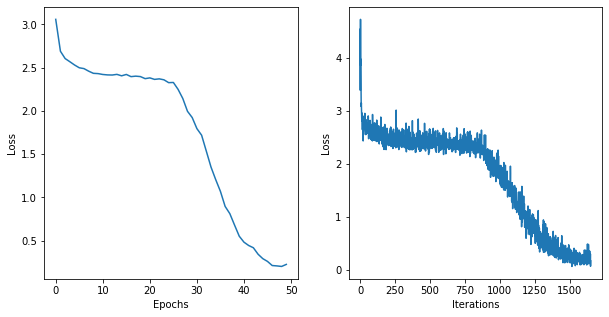

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")

ax2.set_ylabel("Loss")

plt.show()

### Evaluation on validation data 

In [28]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [29]:
def evaluate(model, iterator, results_df):
    epoch_loss = 0
    model.eval()
    
    with torch.no_grad():
        for image_batch, text_batch in tqdm(iterator, leave=True):
            text_batch_logits = model(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
            text_batch_pred = decode_predictions(text_batch_logits.cpu())
            
            loss = compute_loss(text_batch, text_batch_logits)
            
            df = pd.DataFrame(columns=['actual', 'prediction'])
            df['actual'] = text_batch
            df['prediction'] = text_batch_pred
            results_df = pd.concat([results_df, df])
            
            epoch_loss += loss.item()
    results_df = results_df.reset_index(drop=True)
    results_df['prediction_corrected'] = results_df['prediction'].apply(correct_prediction)
    return results_df, epoch_loss / len(iterator)

In [31]:
results_test = pd.DataFrame(columns=['actual', 'prediction'])
test_loader = DataLoader(valid_data, batch_size=16, num_workers=1, shuffle=False)
test_df,loss = evaluate(crnn, test_loader, results_test)
print(f'Test Loss: {loss:.3f}')


Test Loss: 0.400


In [32]:
test_df.head()

,actual,prediction,prediction_corrected
0,9B49365,9BA4A993665,9BA4A9365
1,5Z40181,5BAA4A01181,5BA4A0181
2,7B27150,7BAA2A7A150,7BA2A7A150
3,8T43418,8BAA4A3A418,8BA4A3A418
4,3B75763,3BA7A557633,3BA7A5763


In [35]:
results_train = pd.DataFrame(columns=['actual', 'prediction'])
test_loader = DataLoader(train_data, batch_size=16, num_workers=1, shuffle=False)
train_df,loss = evaluate(crnn, test_loader, results_train)
print(f'Train Loss: {loss:.3f}')


Train Loss: 0.212


In [37]:
#saving trained model
torch.save(crnn.state_dict(), 'output/crnn_50.pt')

In [38]:
results_train = pd.DataFrame(columns=['actual', 'prediction'])
train_loader = DataLoader(train_data, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

In [39]:
print(results_train.shape)
results_train.head()

(521, 2)


,actual,prediction
0,6B51255,6BAAA5125A5
1,7B46204,7BAA4A62202
2,3B48296,3BAA4A82296
3,4M98681,4MAA99A8681
4,8B23170,8BA2A331176


### This simpler model atleast are able to predict alphanumeric sequences on such less training data and we can do some preprocessing steps to remove duplicates or can modify architecture to output sequence length of 7 exactly.

### Refernce from below sources
https://github.com/carnotaur/crnn-tutorial<br>
https://github.com/bentrevett/pytorch-image-classification